# Задание
* Скачать все вакансии СБЕРа с ХХ (у апи есть ограничение в 2000, а также captcha подумайте как их можно обойти)
* Извлеките все описания этих вакансий
* Создайте аналогичный vacancy DataFrame только добавьте поле skills
* Переведите даты публикаций в datetime
* Постройте график опубликованных вакансий по датам
* Переведите даты в дни недели, и определите день недели, в который больше всего публикуют вакансий
* Найдите те вакансии с использованием python, которые вам интересны
* Определите по полю skills какие навыки больше всего востребованы для этих вакансий
* Постройте график наиболее востребованных навыков для аналитика данных

https://github.com/hhru/api

In [263]:
import requests
import json
from tqdm.auto import tqdm
from collections import defaultdict
import pickle
import pandas as pd
import numpy as np

In [49]:
sber = '3529'
page = 1
num_per_page = 100
moscow = 1
url = f'https://api.hh.ru/vacancies?employer_id={sber}&page={page}&per_page={num_per_page}&area={moscow}'

In [50]:
res = requests.get(url)

In [51]:
res.json()

{'items': [{'id': '66117879',
   'premium': False,
   'name': 'Java разработчик',
   'department': {'id': '3529-3529-it', 'name': 'Сбер. IT'},
   'has_test': False,
   'response_letter_required': False,
   'area': {'id': '1', 'name': 'Москва', 'url': 'https://api.hh.ru/areas/1'},
   'salary': None,
   'type': {'id': 'open', 'name': 'Открытая'},
   'address': None,
   'response_url': None,
   'sort_point_distance': None,
   'published_at': '2022-06-20T15:08:56+0300',
   'created_at': '2022-06-20T15:08:56+0300',
   'archived': False,
   'apply_alternate_url': 'https://hh.ru/applicant/vacancy_response?vacancyId=66117879',
   'insider_interview': None,
   'url': 'https://api.hh.ru/vacancies/66117879?host=hh.ru',
   'adv_response_url': 'https://api.hh.ru/vacancies/66117879/adv_response?host=hh.ru',
   'alternate_url': 'https://hh.ru/vacancy/66117879',
   'relations': [],
   'employer': {'id': '3529',
    'name': 'СБЕР',
    'url': 'https://api.hh.ru/employers/3529',
    'alternate_url': 'ht

In [52]:
vacs = res.json()
num_pages = vacs.get('pages')
num_pages

13

In [53]:
print(f"Всего найдено {vacs['found']} вакансий")

Всего найдено 1233 вакансий


### Скачать все вакансии СБЕРа с ХХ

In [58]:
vacancies = []

for pg in range(vacs['pages']):
    url = f'https://api.hh.ru/vacancies?employer_id={sber}&page={pg}&per_page={num_per_page}&area={moscow}'
    res = requests.get(url)
    vacs = res.json()
    vacancies += vacs['items']

In [59]:
print(f'Всего скачали {len(vacancies)} вакансии')

Всего скачали 1233 вакансии


### Извлеките все описания этих вакансий

Соберем полную информацию о вакансиях по их ID.

In [77]:
# 628

all_info_vacs = []
vacancy_ids = [el['id'] for el in vacancies]

for v_id in tqdm(vacancy_ids):
    url = f'https://api.hh.ru/vacancies/{v_id}'
    res = requests.get(url)
    vac = res.json()
    all_info_vacs.append(vac)

  0%|          | 0/1233 [00:00<?, ?it/s]

In [79]:
print(f'Всего скачали полную информацию о {len(all_info_vacs)} вакансий.')

Всего скачали полную информацию о 1233 вакансий.


In [85]:
descriptions = {vac['id'] : vac['description'] for vac in all_info_vacs}
print('Все описания вакансий содержаться в словаре descriptions')

Все описания вакансий содержаться в словаре descriptions


### Создайте аналогичный vacancy DataFrame только добавьте поле skills

In [278]:
cols = vacancies[0].keys()

In [279]:
df = pd.DataFrame()

for col in cols:
    s = pd.Series([el[col] for el in vacancies])
    df[col] = s
    
df['skills'] = pd.Series([el['key_skills'] for el in all_info_vacs])

In [280]:
# Размер получившегося датафрейма
df.shape

(1233, 30)

In [281]:
df.head(3)

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,relations,employer,snippet,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,skills
0,55415805,False,Менеджер по работе с клиентами,"{'id': '3529-3529-stat', 'name': 'Сбер. Начало...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 98800, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",None,...,[],"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...",{'requirement': 'Опыт работы консультантом или...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,[]
1,53361761,False,Клиентский менеджер малого и микробизнеса,"{'id': '3529-3529-prof', 'name': 'Сбер для экс...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 93900, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",None,...,[],"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...",{'requirement': 'высшее образование (финансы/б...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,"[{'name': 'Активные продажи'}, {'name': 'Прове..."
2,55415496,False,Клиентский менеджер прямых продаж,"{'id': '3529-3529-stat', 'name': 'Сбер. Начало...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 98800, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",None,...,[],"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...","{'requirement': None, 'responsibility': 'Выезж...",None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,[]


### Переведите даты публикаций в datetime

In [282]:
# Пока у поля "Дата публикации" тип object

df['published_at'].head(3)

0    2022-07-06T13:45:50+0300
1    2022-06-27T12:47:08+0300
2    2022-06-29T19:44:36+0300
Name: published_at, dtype: object

In [283]:
# переведем дату в формат datetime

df['published_at'] = pd.to_datetime(df['published_at'])

In [284]:
# Теперь у поля "Дата публикации" тип datetime64

df['published_at'].head(3)

0   2022-07-06 13:45:50+03:00
1   2022-06-27 12:47:08+03:00
2   2022-06-29 19:44:36+03:00
Name: published_at, dtype: datetime64[ns, pytz.FixedOffset(180)]

### Постройте график опубликованных вакансий по датам

<AxesSubplot:>

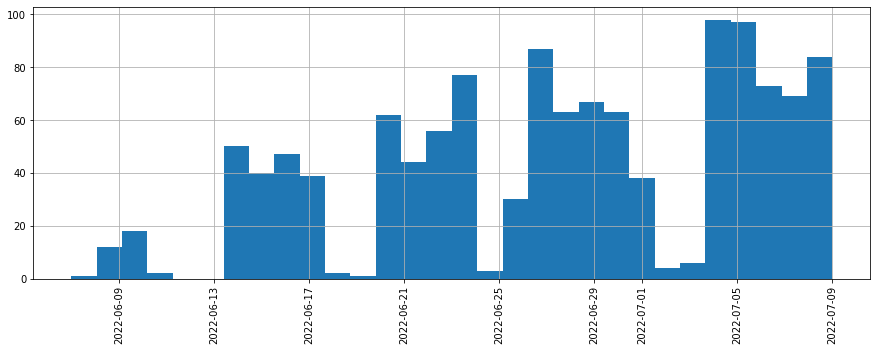

In [285]:
df['published_at'].dt.date.hist(bins=30, figsize=(15, 5), xrot=90)

### Переведите даты в дни недели, и определите день недели, в который больше всего публикуют вакансий

In [286]:
df['day_of_week'] = df['published_at'].dt.day_of_week

<AxesSubplot:>

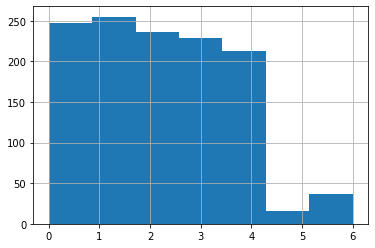

In [287]:
df['day_of_week'].hist(bins=7)

In [288]:
df.groupby('day_of_week').size().idxmax()

1

Максимальное количество вакансий публикуется во вторник.

### Найдите те вакансии с использованием python, которые вам интересны

In [289]:
# Переведем все навыки из словаря в список

df.skills = df.skills.apply(lambda x: np.reshape([list(el.values()) for el in x],len(x) ))
df.head()

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,employer,snippet,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,skills,day_of_week
0,55415805,False,Менеджер по работе с клиентами,"{'id': '3529-3529-stat', 'name': 'Сбер. Начало...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 98800, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...",{'requirement': 'Опыт работы консультантом или...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,[],2
1,53361761,False,Клиентский менеджер малого и микробизнеса,"{'id': '3529-3529-prof', 'name': 'Сбер для экс...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 93900, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...",{'requirement': 'высшее образование (финансы/б...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,"[Активные продажи, Проведение презентаций, При...",0
2,55415496,False,Клиентский менеджер прямых продаж,"{'id': '3529-3529-stat', 'name': 'Сбер. Начало...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 98800, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...","{'requirement': None, 'responsibility': 'Выезж...",None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,[],2
3,45790891,False,Менеджер по работе с ключевыми клиентами малог...,"{'id': '3529-3529-prof', 'name': 'Сбер для экс...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 119300, 'to': None, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...",{'requirement': 'Высшее или неполное высшее об...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,"[Прямые продажи, Финансовый анализ, Клиентоори...",3
4,45381514,False,Старший менеджер по привлечению корпоративных ...,"{'id': '3529-3529-prof', 'name': 'Сбер для экс...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 146400, 'to': None, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...",{'requirement': 'Высшее или неполное высшее об...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,"[Холодные продажи, Поиск и привлечение клиенто...",3


In [290]:
python_vacs = df[df.skills.apply(lambda x: 'python' in map(lambda y: y.lower(), x))]

print(f'Всего найдено {python_vacs.shape[0]} вакансий с использованием Python')

Всего найдено 148 вакансий с использованием Python


In [292]:
# Найдем вакансии data analyst и data scientist
interested_vacs = python_vacs[
((python_vacs.name.str.lower().str.find('data analyst') > -1) | \
(python_vacs.name.str.lower().str.find('data аналитик') > -1) | \
(python_vacs.name.str.lower().str.find('аналитик данных') > -1) | \
(python_vacs.name.str.lower().str.find('data scientist') > -1)) & \
(python_vacs.name.str.lower().str.find('стажер') == -1)
]

interested_vacs.head(3)

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,employer,snippet,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,skills,day_of_week
102,55138654,False,Data Analyst (Рекомендательная система),"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...",{'requirement': 'Мотивация учиться и развивать...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,"[Python, SQL, PostgreSQL, Git, Atlassian Jira]",4
144,51784863,False,Data Scientist (SberDevices),"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Кутузовский прос...",...,"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...",{'requirement': 'Глубокое понимание нейросетев...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,"[PyTorch, Tensorflow, Python, Deep Learning, NLP]",3
153,66232494,False,Data scientist,"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...",{'requirement': 'Знание подходов к тестировани...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,"[Python, Английский язык, Numpy, SQL, Linux]",1


In [293]:
print(f'Всего найдено {interested_vacs.shape[0]} интересных вакансий с использованием Python')

Всего найдено 21 интересных вакансий с использованием Python


### Определите по полю skills какие навыки больше всего востребованы для этих вакансий

In [294]:
from functools import reduce

all_skills = pd.Series(reduce(lambda x, y: x+y, interested_vacs.skills.apply(list)))

In [295]:
# Наиболее востребованные навыки для интересных вакансий

need_skills = all_skills.value_counts()[all_skills.value_counts() > 1]
need_skills

Python                   21
SQL                      13
Hadoop                    6
Spark                     5
Linux                     5
SCALA                     4
ML                        3
NLP                       3
Английский язык           3
Numpy                     3
Pandas                    3
Hive                      2
Data Mining               2
Анализ данных             2
Математический анализ     2
Deep Learning             2
Tensorflow                2
PyTorch                   2
Atlassian Jira            2
Git                       2
dtype: int64

<AxesSubplot:>

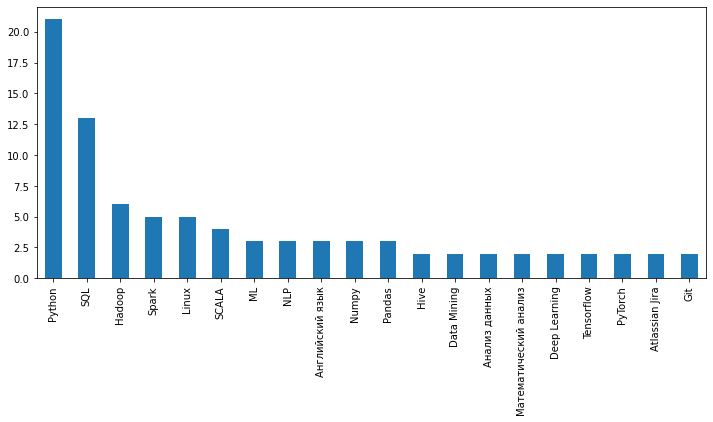

In [297]:
need_skills.plot(kind='bar', figsize=(12,5))

### Постройте график наиболее востребованных навыков для аналитика данных

In [299]:
# Найдем вакансии аналитика данных
data_analyst_vacs = df[
(df.name.str.lower().str.find('data analyst') > -1) | \
(df.name.str.lower().str.find('data аналитик') > -1) | \
(df.name.str.lower().str.find('аналитик данных') > -1) 
]

data_analyst_vacs.head(3)

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,employer,snippet,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,skills,day_of_week
34,67494236,False,Junior data analyst,"{'id': '3529-3529-prof', 'name': 'Сбер для экс...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...",{'requirement': 'Знания принципов работы BigDa...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,[],1
69,67346866,False,Аналитик данных (campaign analyst),"{'id': '3529-3529-prof', 'name': 'Сбер для экс...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...",{'requirement': 'Знание SQL (запросы ко множес...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,[],2
102,55138654,False,Data Analyst (Рекомендательная система),"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...",{'requirement': 'Мотивация учиться и развивать...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,"[Python, SQL, PostgreSQL, Git, Atlassian Jira]",4


In [300]:
print(f'Всего найдено {data_analyst_vacs.shape[0]} вакансий аналитика данных')

Всего найдено 19 вакансий аналитика данных


In [302]:
data_analyst_all_skills = pd.Series(reduce(lambda x, y: x+y, data_analyst_vacs.skills.apply(list)))

In [303]:
# Наиболее востребованные навыки для аналитика данных

data_analyst_skills = data_analyst_all_skills.value_counts()[data_analyst_all_skills.value_counts() > 1]
data_analyst_skills

SQL               9
Python            7
Spark             5
Hadoop            5
Анализ данных     3
Atlassian Jira    2
SCALA             2
ETL               2
dtype: int64

<AxesSubplot:>

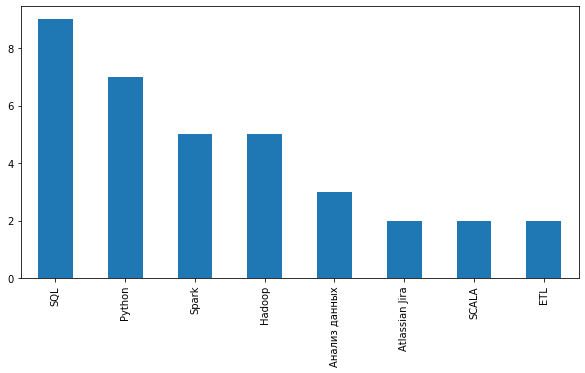

In [305]:
data_analyst_skills.plot(kind='bar', figsize=(10,5))